In [1]:
from PIL import Image #import Python Image Library
import numpy as np
import os
import glob
import re
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import mlutils
import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.
/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Descarga de imágenes
Se crea un directorio para almacenar las imágenes, una vez crea no vuelve a ejecutar los comandos.

In [2]:
directorio = os.listdir('./') 
if 'ImgsSat' in directorio:
    pass
else:
    !mkdir ImgsSat
    !wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -P ImgsSat
    !unzip ImgsSat/EuroSAT.zip -d ImgsSat

# Separación de las imágenes en train y test

Se evalua dos formas de crear las imagenes de train y test, donde se encuentra que la primera es más eficiente, ya que toma menos tiempo y se obtiene el mismo resultado.

Se hace una distribución del 70% para train y 30% para el test

In [3]:
#(En máquina virtual tarda unos # minutos)
import random
import shutil

random.seed(42)
# variables
path_to_all_images = "ImgsSat/2750" #Carpeta donde están las imágenes
path_to_split_datasets = "split" #Carpeta donde se van a separar
percentage_validation = 0.3 # percentage of validation data (between 0 an 1)
delete_old_path_to_split_datasets = True #Borrar los train-test anteriores

# Rutas a las carpetas
path_to_home = os.path.expanduser("~")
path_to_all_images = path_to_all_images.replace("~", path_to_home)
path_to_split_datasets = path_to_split_datasets.replace("~", path_to_home)
# Borra y crea carpetas
shutil.rmtree('split')
os.makedirs('split')
if delete_old_path_to_split_datasets and os.path.isdir(path_to_split_datasets):
    shutil.rmtree(path_to_split_datasets)
path_to_train = os.path.join(path_to_split_datasets, "train")
path_to_validation = os.path.join(path_to_split_datasets, "test")
if not os.path.isdir(path_to_train):
    os.makedirs(path_to_train)
if not os.path.isdir(path_to_validation):
    os.makedirs(path_to_validation)

# Copia los archivos
sub_dirs = [sub_dir for sub_dir in os.listdir(path_to_all_images)
            if os.path.isdir(os.path.join(path_to_all_images, sub_dir))] #Clases
for sub_dir in mlutils.pbar()(sub_dirs):
    # list and shuffle images in class directories
    current_dir = os.path.join(path_to_all_images, sub_dir)
    files = os.listdir(current_dir)
    random.shuffle(files)
    # split files into train and validation set
    split_idx = int(len(files)*percentage_validation)
    files_for_validation = files[:split_idx]
    files_for_train = files[split_idx:]
    # copy files to path_to_split_datasets
    if not os.path.isdir(os.path.join(path_to_train, sub_dir)):
        os.makedirs(os.path.join(path_to_train, sub_dir))
    if not os.path.isdir(os.path.join(path_to_validation, sub_dir)):
        os.makedirs(os.path.join(path_to_validation, sub_dir))
    for file in files_for_train:
        shutil.copy2(os.path.join(current_dir, file),
                     os.path.join(path_to_train, sub_dir))
    for file in files_for_validation:
        shutil.copy2(os.path.join(current_dir, file),
                     os.path.join(path_to_validation, sub_dir))

100% (10 of 10) |#########################| Elapsed Time: 0:03:50 Time: 0:03:50


In [4]:
# ##!!!!!Forma alternativa de separación, requiere mas tiempo!!!!!!!!!!!!!!!!
# for classdir in classdirs:
#     print classdir
#     print "    splitting files ... ",
#     files = !find $downloads/$classdir -type f
#     files = np.r_[files]
#     n_train = int(len(files)*train_pct) 
#     files = np.random.permutation(files)
#     files_train = files[:n_train]
#     files_test  = files[n_train:]
#     !mkdir -p $traintest_imgs/train/$classdir
#     !mkdir -p $traintest_imgs/test/$classdir
#     print "copying files"
#     for f in files_train:
#         !cp '$f' $traintest_imgs/train/$classdir
#     for f in files_test:
#         !cp '$f' $traintest_imgs/test/$classdir

In [5]:
#nombres de categorías
downloads = "Images" #Direcciones donde se guardarán las imgs
traintest_imgs = "split"
train_pct = .7
classdirs = !find $downloads -type d
classdirs = [i.split("/")[-1] for i in classdirs if i!=downloads]
#Saber número de imágenes para train y test de cada categoría
for classdir in classdirs:
    print classdir
    files = !find  $traintest_imgs/train/$classdir -type f
    print "      ",len(files), "train images"
    files = !find  $traintest_imgs/test/$classdir -type f
    print "      ",len(files), "test images"

.ipynb_checkpoints
       1 train images
       1 test images


In [45]:
#Generador de las imágenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(rescale=1./255, fill_mode='nearest')
batch_size = 50
img_size = 64 #resolución de las imágenes
train_generator_fn = lambda: datagen.flow_from_directory( ## fits the model on batches with real-time data augmentation:
        traintest_imgs+"/train",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized 
        batch_size=batch_size,
        interpolation = "bilinear",
        #class_mode='binary') 
        class_mode='sparse') 

test_generator_fn = lambda: datagen.flow_from_directory(
        traintest_imgs+"/test",  # this is the target directory
        target_size=(img_size, img_size),  # all images will be resized
        batch_size=batch_size,
        interpolation = "bilinear",
        #class_mode='binary') 
        class_mode='sparse') 

Found 18900 images belonging to 10 classes.


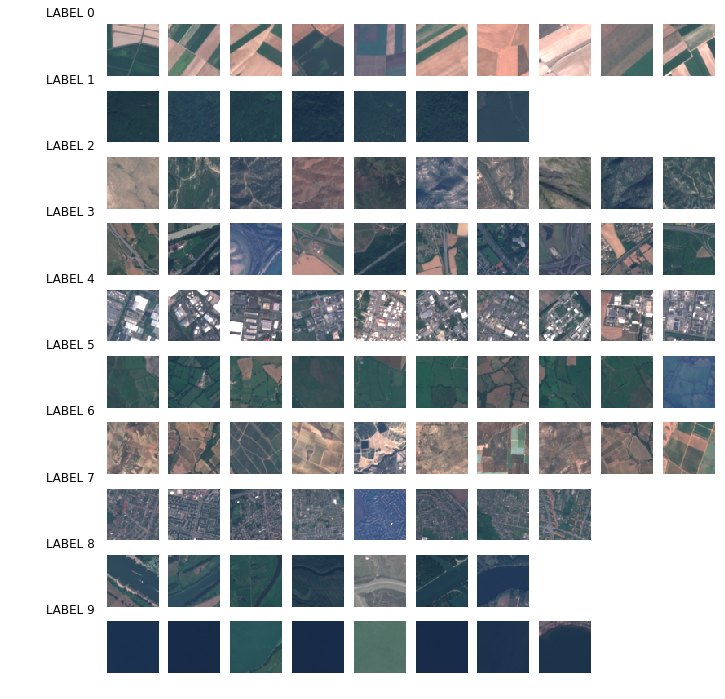

In [44]:
#contador = 0
for imgs,labels in train_generator_fn():
    if np.random.random()>.1:
        break
    #if contador == 100:
    #    break
    #contador+=1
reload(mlutils)        
mlutils.show_labeled_image_mosaic(imgs, labels)

## Experimentación
Aquí se busca definir varias arquitecturas para selección la más adecuada para el objetivo del proyecto

Donde se varía el optimizador, la función de pérdida, el número de capas, las funciones de activación, padding y las epocas en el generador de imágenes.

Para esto se van a crear 4 modelos diferentes (A, B, C, D) con las variaciones antes mencionadas.

Y se variarán las epocas entre 1 y 3.


In [46]:
#Modelo A
from keras import optimizers
def get_conv_model_A(num_classes, img_size=64, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"  
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(2,2), activation="relu", padding="SAME")(inputs) #, padding="SAME"se debería usar padding por
    #el tamaño pequeño de las imágenes
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(layers)
    #layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    #layers = tf.keras.layers.Conv2D(128,(22,22), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        #Optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.3, decay=0, nesterov=False)
        model.compile(optimizer='sgd',#'adam',#Optimizer,
                      loss='sparse_categorical_crossentropy',#tf.keras.losses.mean_squared_error,
                      metrics=['accuracy'])
    return model

#Modelo B
from keras import optimizers
def get_conv_model_B(num_classes, img_size=64, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"  
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(2,2), activation="relu", padding="VALID")(inputs) #, padding="SAME"se debería usar padding por
    #el tamaño pequeño de las imágenes
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    #layers = tf.keras.layers.Conv2D(128,(22,22), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        #Optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.3, decay=0, nesterov=False)
        model.compile(optimizer='sgd',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

#Modelo C
from keras import optimizers
def get_conv_model_C(num_classes, img_size=64, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"  
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(2,2), activation="sigmoid", padding="VALID")(inputs) #, padding="SAME"se debería usar padding por
    #el tamaño pequeño de las imágenes
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="sigmoid")(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="sigmoid")(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    #layers = tf.keras.layers.Conv2D(128,(22,22), activation="sigmoid")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.sigmoid)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.sigmoid)(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.sigmoid)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        Optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.3, decay=0, nesterov=False)
        model.compile(optimizer=Optimizer,
                      loss='sparse_categorical_crossentropy',#tf.keras.losses.mean_squared_error,
                      metrics=['accuracy'])
    return model

#Modelo D
from keras import optimizers
def get_conv_model_D(num_classes, img_size=64, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"  
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(2,2), activation="tanh", padding="SAME")(inputs) #, padding="SAME"se debería usar padding por
    #el tamaño pequeño de las imágenes
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="tanh")(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="tanh")(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    #layers = tf.keras.layers.Conv2D(128,(22,22), activation="tanh")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.tanh)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.tanh)(layers)
    layers = tf.keras.layers.Dense(128, activation=tf.nn.tanh)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        #Optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.3, decay=0, nesterov=False)
        model.compile(optimizer='sgd',#'adam',#Optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model


In [47]:
num_classes = len(sub_dirs)
modelA = get_conv_model_A(num_classes, img_size=img_size)

modelA.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=3,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)
print('Variación epocas y pasos por epoca')
modelA.fit_generator(
        train_generator_fn(),
        steps_per_epoch=100 // batch_size,
        epochs=2,
        validation_data=test_generator_fn(),
        validation_steps=50 // batch_size)
print('Variación epocas y pasos por epoca')
modelA.fit_generator(
        train_generator_fn(),
        steps_per_epoch=100 // batch_size,
        epochs=1,
        validation_data=test_generator_fn(),
        validation_steps=50 // batch_size)

using 10 classes
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.
Epoch 1/3
20/20 [==============================] - 461s 23s/step - loss: 2.3021 - acc: 0.1010 - val_loss: 2.2930 - val_acc: 0.0900
Epoch 2/3
20/20 [==============================] - 390s 20s/step - loss: 2.2814 - acc: 0.1070 - val_loss: 2.2833 - val_acc: 0.0700
Epoch 3/3
20/20 [==============================] - 449s 22s/step - loss: 2.2730 - acc: 0.1080 - val_loss: 2.2660 - val_acc: 0.1050
Variación epocas y pasos por epoca
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.
Epoch 1/2
1/2 [==============>...............] - ETA: 17s - loss: 2.2843 - acc: 0.0800

UnboundLocalError: local variable 'outs' referenced before assignment

In [49]:
modelB = get_conv_model_B(num_classes, img_size=img_size)
modelB.fit_generator(
        train_generator_fn(),
        steps_per_epoch=100 // batch_size,
        epochs=2,
        validation_data=test_generator_fn(),
        validation_steps=50 // batch_size)
print('Variación epocas y pasos por epoca')
modelB.fit_generator(
        train_generator_fn(),
        steps_per_epoch=100 // batch_size,
        epochs=1,
        validation_data=test_generator_fn(),
        validation_steps=50 // batch_size)

using 10 classes
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.
Epoch 1/2
2/2 [==============================] - 52s 26s/step - loss: 2.3015 - acc: 0.1000 - val_loss: 2.2995 - val_acc: 0.0800
Epoch 2/2
2/2 [==============================] - 46s 23s/step - loss: 2.2998 - acc: 0.1300 - val_loss: 2.2987 - val_acc: 0.0800
Variación epocas y pasos por epoca
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.
Epoch 1/1
2/2 [==============================] - 51s 25s/step - loss: 2.2985 - acc: 0.1500 - val_loss: 2.2957 - val_acc: 0.1000


In [41]:
modelC = get_conv_model_C(num_classes, img_size=img_size)
modelC.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=3,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)
print('Variación epocas y pasos por epoca')
modelC.fit_generator(
        train_generator_fn(),
        steps_per_epoch=100 // batch_size,
        epochs=2,
        validation_data=test_generator_fn(),
        validation_steps=40 // batch_size)
print('Variación epocas y pasos por epoca')
modelC.fit_generator(
        train_generator_fn(),
        steps_per_epoch=10 // batch_size,
        epochs=1,
        validation_data=test_generator_fn(),
        validation_steps=40 // batch_size)

using 10 classes
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.
Epoch 1/3
100/100 [==============================] - 693s 7s/step - loss: 2.4035 - acc: 0.1050 - val_loss: 2.3340 - val_acc: 0.0925
Epoch 2/3
100/100 [==============================] - 692s 7s/step - loss: 2.3725 - acc: 0.1070 - val_loss: 2.3137 - val_acc: 0.0925
Epoch 3/3
100/100 [==============================] - 709s 7s/step - loss: 2.3739 - acc: 0.1050 - val_loss: 2.3014 - val_acc: 0.0925
Variación epocas y pasos por epoca
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.
Epoch 1/2
10/10 [==============================] - 61s 6s/step - loss: 2.3468 - acc: 0.1400 - val_loss: 2.3038 - val_acc: 0.0750
Epoch 2/2
10/10 [==============================] - 73s 7s/step - loss: 2.3381 - acc: 0.1200 - val_loss: 2.3027 - val_acc: 0.0750
Variación epocas y pasos por epoca
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes

In [49]:
modelD = get_conv_model_D(num_classes, img_size=img_size)
modelD.fit_generator(
        train_generator_fn(),
        steps_per_epoch=1000 // batch_size,
        epochs=3,
        validation_data=test_generator_fn(),
        validation_steps=400 // batch_size)
print('Variación epocas y pasos por epoca')
modelD.fit_generator(
        train_generator_fn(),
        steps_per_epoch=100 // batch_size,
        epochs=2,
        validation_data=test_generator_fn(),
        validation_steps=40 // batch_size)
print('Variación epocas')
modelD.fit_generator(
        train_generator_fn(),
        steps_per_epoch=100 // batch_size,
        epochs=1,
        validation_data=test_generator_fn(),
        validation_steps=40 // batch_size)

using 10 classes
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.
Epoch 1/3
100/100 [==============================] - 708s 7s/step - loss: 2.3678 - acc: 0.1170 - val_loss: 2.0307 - val_acc: 0.2275
Epoch 2/3
100/100 [==============================] - 658s 7s/step - loss: 2.0616 - acc: 0.2120 - val_loss: 1.8997 - val_acc: 0.2600
Epoch 3/3
100/100 [==============================] - 825s 8s/step - loss: 1.9559 - acc: 0.2310 - val_loss: 1.9774 - val_acc: 0.2375
Variación epocas y pasos por epoca
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.
Epoch 1/2
10/10 [==============================] - 88s 9s/step - loss: 1.8219 - acc: 0.2900 - val_loss: 1.9586 - val_acc: 0.3750
Epoch 2/2
10/10 [==============================] - 71s 7s/step - loss: 1.9331 - acc: 0.2400 - val_loss: 2.0249 - val_acc: 0.2000
Variación epocas
Found 18900 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.
Epoch 1/1
10/10 

## Resultado

El que mejor resultado obtuvo fue el modelo A, sobre este se define una función que permite observar algunas de las predicciones, de la imagenes y el resultado sobre las 10 clases, que despues de varias pruebas alcanza un 35% de precisión


In [50]:
def show_preds(x, preds):
    for i  in np.random.permutation(range(len(preds)))[:4]:
        plt.figure(figsize=(5,2.5))
        plt.subplot(122)
        plt.imshow(x[i])
        plt.axis("off")
        plt.subplot(121)
        plt.bar(np.arange(2), preds[i], color="blue", alpha=.5, label="prediction")
        plt.bar(np.arange(2), np.eye(2,2)[int(y[i])], color="red", alpha=.5, label="label")
        plt.xticks(range(2), range(2), rotation="vertical");
        plt.xlim(-.5,1.5);
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, +1.35),ncol=5)

Found 8100 images belonging to 10 classes.


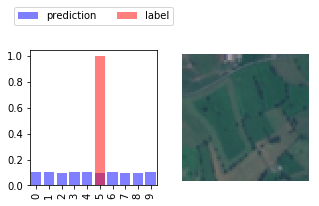

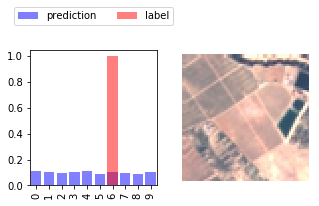

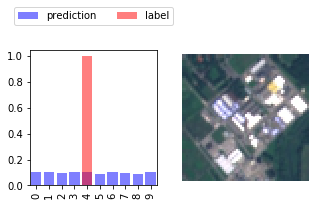

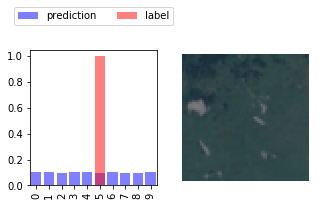

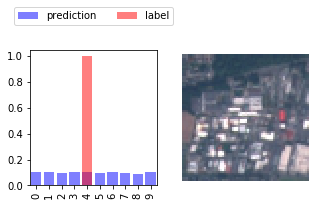

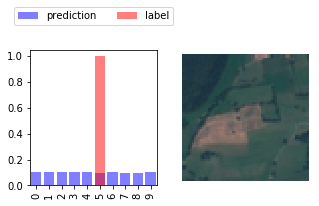

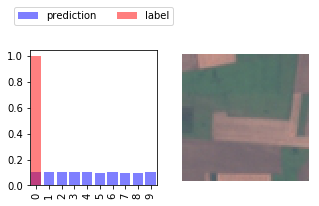

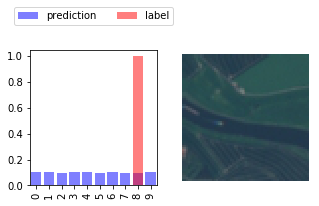

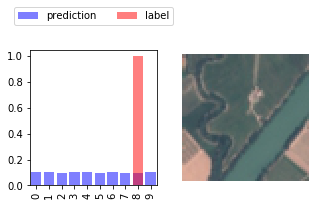

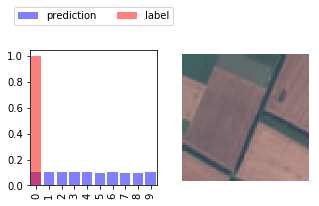

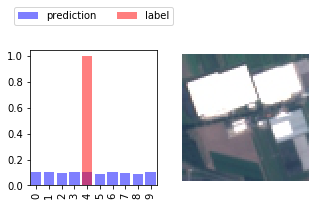

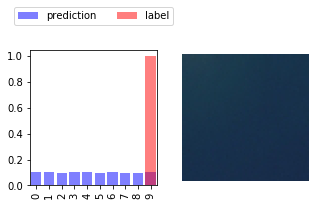

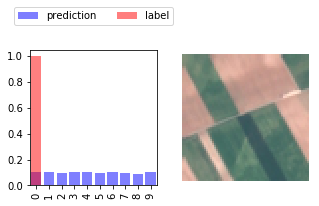

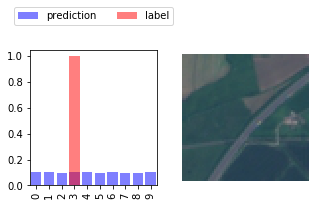

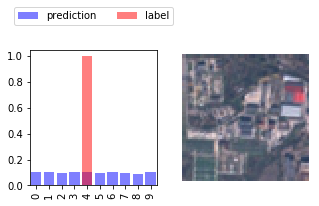

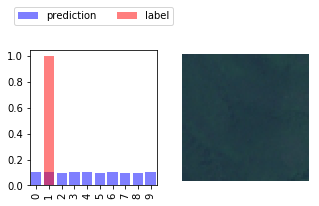

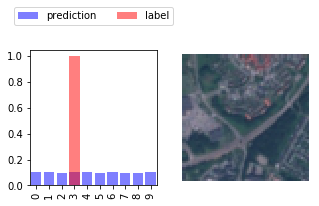

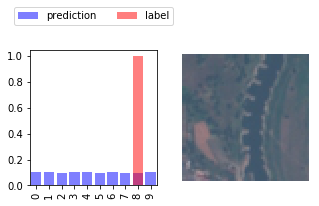

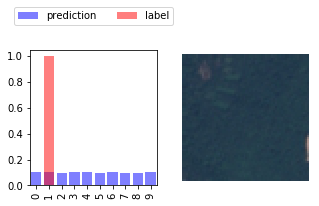

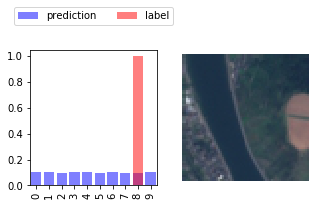

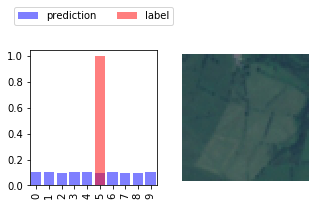

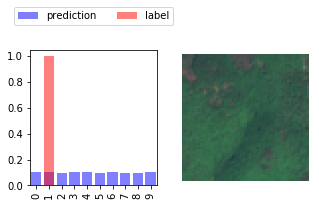

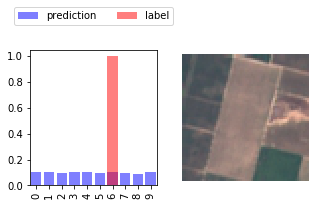

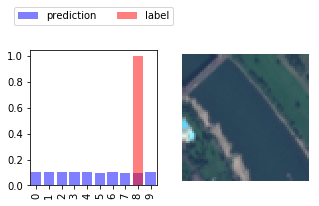

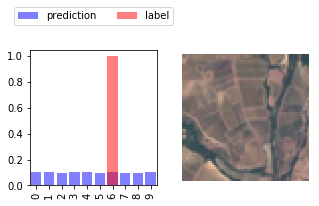

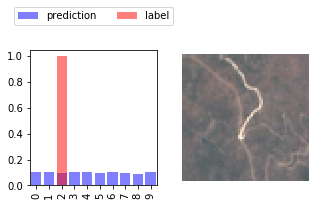

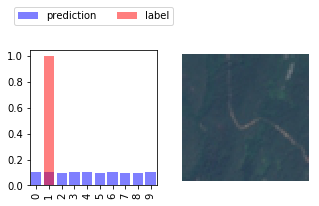

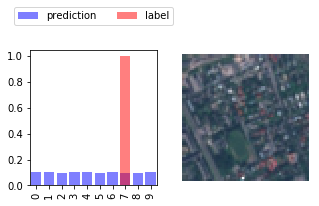

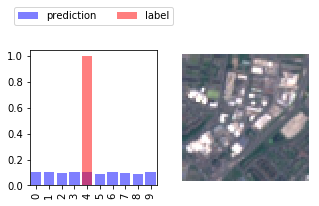

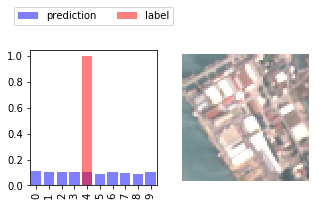

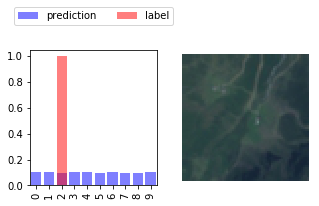

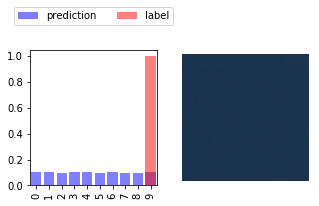

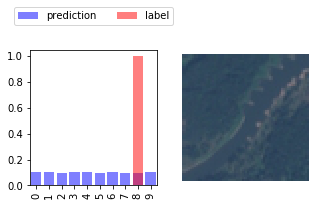

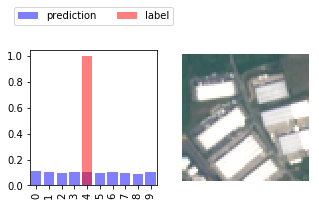

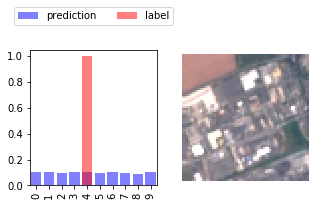

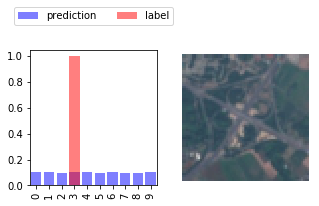

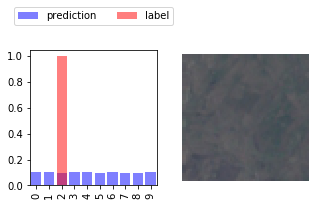

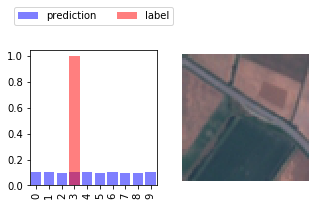

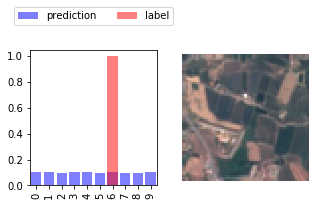

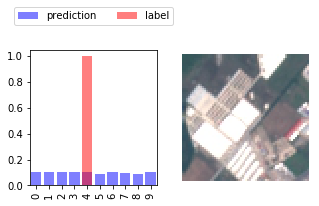

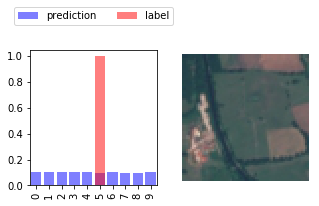

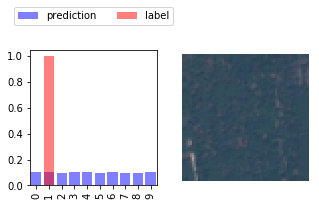

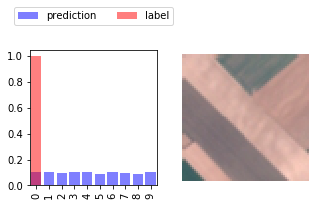

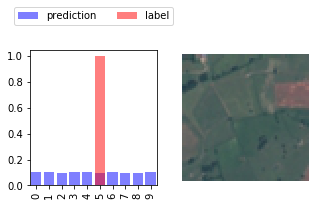

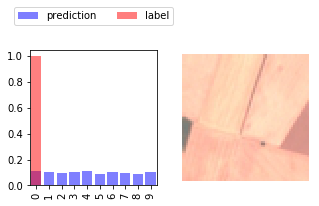

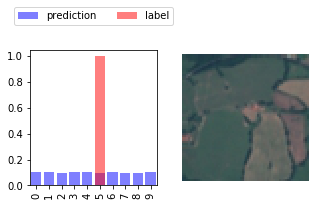

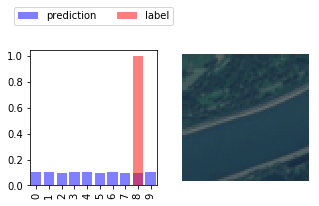

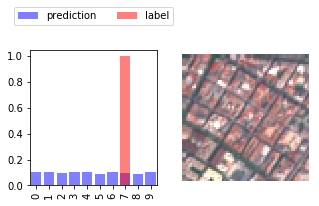

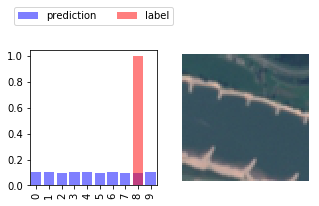

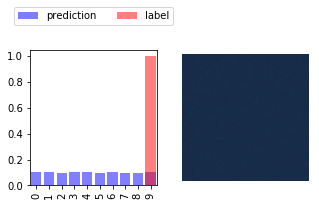

In [56]:
for x,y in test_generator_fn():
    if np.random.random()>.7:
        break
        
#preds = model.predict(x)
preds = modelB.predict(x)
mlutils.show_preds(x, y, preds)

## Resumen modelo

In [64]:
modelA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 96)        1248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 96)        1115232   
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 96)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46464)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5947520   
__________

In [63]:
clases = ['AnnualCrop','Forest','HerbaceousVeg','Highway','Industrial','Pasture', 'PermanentCrop','Residential','River','SeaLake']
clases_dict = dict(enumerate(clases))
clases_dict

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVeg',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}